# Исследование задержек авиаперелётов

## В этом ноутбуке исследовалась зависимость задержек авиарейсов в 3 аэропортах Нью-Йорка от погодных условий и других параметров в 2013 году. Данные брались из следующих датасетов: [1](https://vk.com/away.php?to=https%3A%2F%2Fraw.githubusercontent.com%2Fvaibhavwalvekar%2FNYC-Flights-2013-Dataset-Analysis%2Fmaster%2Fflights.csv&post=-198454123_16&cc_key=) [2](https://vk.com/away.php?to=https%3A%2F%2Fgithub.com%2Fvaibhavwalvekar%2FNYC-Flights-2013-Dataset-Analysis%2Fblob%2Fmaster%2Fweather.csv&post=-198454123_16&cc_key=). Для того, чтобы гипотезы были более достоверными и можно было отличить общие выводы от возможных особенностей аэропорта, статистики строилась по данным из разных аэропортов отдельно. Так например опоздания пассажиров могут быть связаны как с географическим положением аэропорта, загруженностью дорог в этом районе итп так и с общими данными такими как время суток.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
weather_path = r"https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/weather.csv"
weather = pd.read_csv(weather_path, sep=',') 

In [5]:
delays_path = r"https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/flights.csv"
delays = pd.read_csv(delays_path)

In [6]:
ewr = delays[delays['origin'] == 'EWR']
lga = delays[delays['origin'] == 'LGA']
jfk = delays[delays['origin'] == 'JFK']

Построим график зависимости среднего времени задержек от времени суток. 

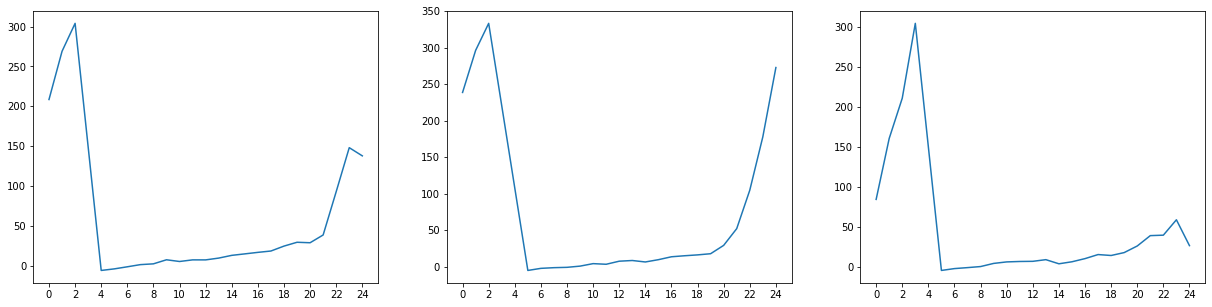

In [13]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
plt.setp(ax, xticks=np.arange(0, 25, 2))
for i, airport in enumerate([ewr, lga, jfk]):
  ax[i].plot(np.sort(airport['hour'][airport['hour'].notna()].unique()), airport.groupby(['hour'])['dep_delay'].mean())
plt.show()

Для всех аэропортов задержка резко растёт от 0 до ~3 часов, затем резко падает до минимального уровня вплоть до ~4-5 часов, и затем плавно поднимается вплоть до ~20 часов.
Отличия наблюдая на на этапе от ~20 до 24 часов, что видимо может быть связано с особенностями расположения аэропортов или другими характеристиками.

Построим cтолбчатые диаграмма для зависимости положительных, общих и нулевых средних задержек от месяца для всех аэропортов.

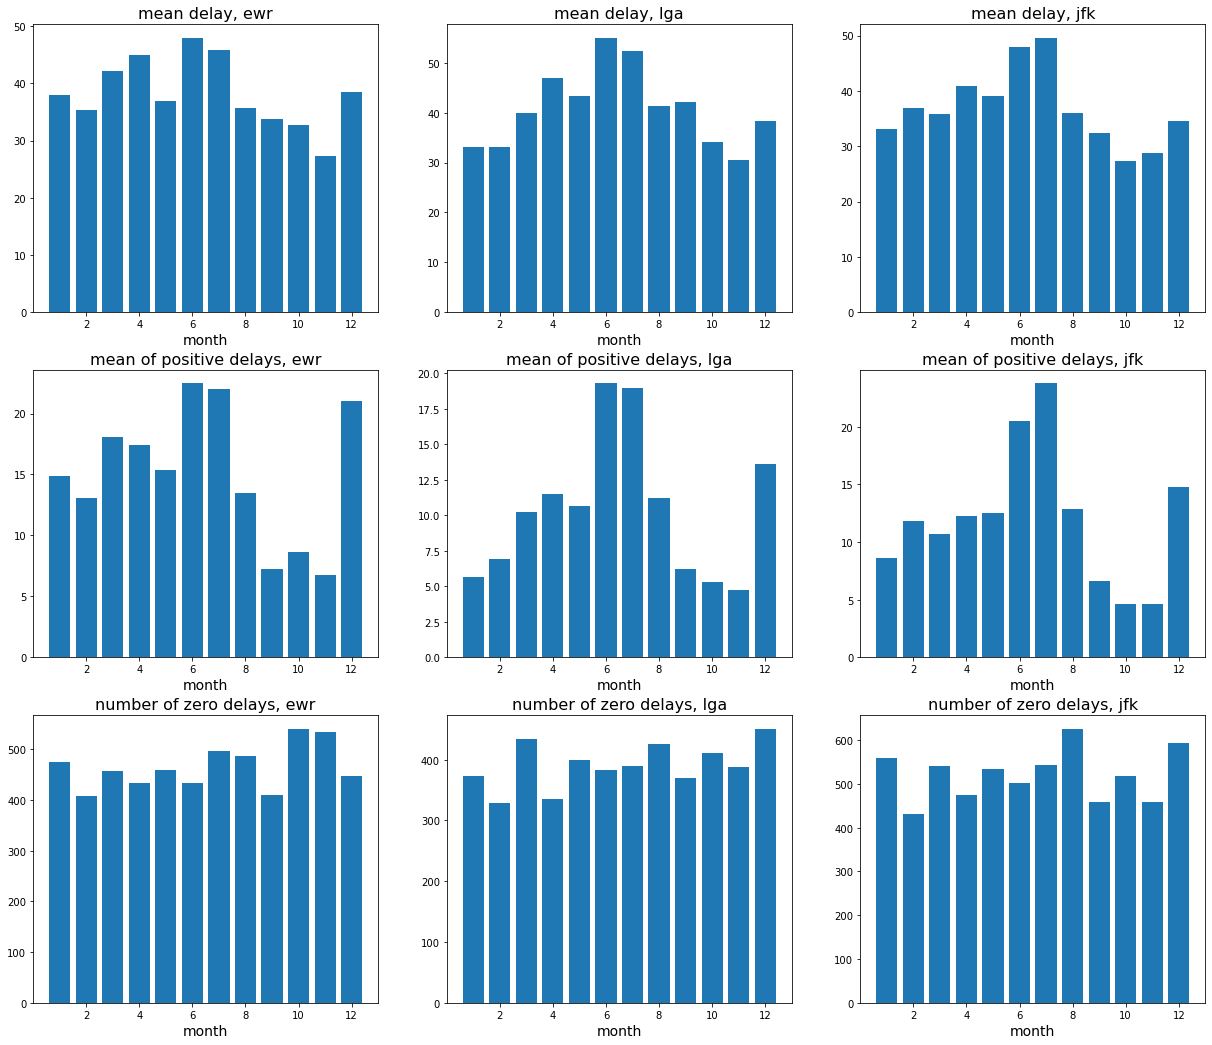

In [21]:
_, ax = plt.subplots(3, 3, figsize = (21, 18))
airport_names = ['ewr', 'lga', 'jfk']
for idx, airport in enumerate([ewr, lga, jfk]):
  titles = ['mean delay', 'mean of positive delays', 'number of zero delays']
  ax[0][idx].bar(np.arange(1, 13), airport[airport['dep_delay'] > 0].groupby(['month'])['dep_delay'].mean())
  ax[1][idx].bar(np.arange(1, 13), airport.groupby(['month'])['dep_delay'].mean())
  ax[2][idx].bar(np.arange(1, 13), airport[airport['dep_delay'] == 0].groupby(['month'])['dep_delay'].count())
  for i in range(3):
    ax[i][idx].set_xlabel('month', fontsize = 14)
    ax[i][idx].set_title(titles[i] + ', ' + airport_names[idx], fontsize = 16)
plt.show()

По построенным графикам видно, что задержка была максимальной в июне и июле для всех аэропортов.

Построим диаграммы зависимости задержек от дня недели.

In [23]:
import datetime
from numba import jit

week_dict = {}
for i in range(1, 366):
  date = datetime.datetime(2013, 1, 1) + datetime.timedelta(i - 1)
  m = str(date)[5:7]
  d = str(date)[8:10]
  week_dict[m + d] = int(date.weekday())
output = np.zeros(len(delays))
datenp = np.asarray(delays[['month', 'day']])

def outp(output, datenp, week_dict):
  for idx, item in enumerate(datenp):
    m, d = str(item[0]), str(item[1])
    if len(m) == 1:
      m = '0' + m
    if len(d) == 1:
      d = '0' + d
    output[idx] = week_dict[m + d]
outp(output, datenp, week_dict)


In [25]:
if 'week day' in delays:
  delays = delays.drop(columns = ['week day'])
delays.insert(2, 'week day', output.astype(np.int))

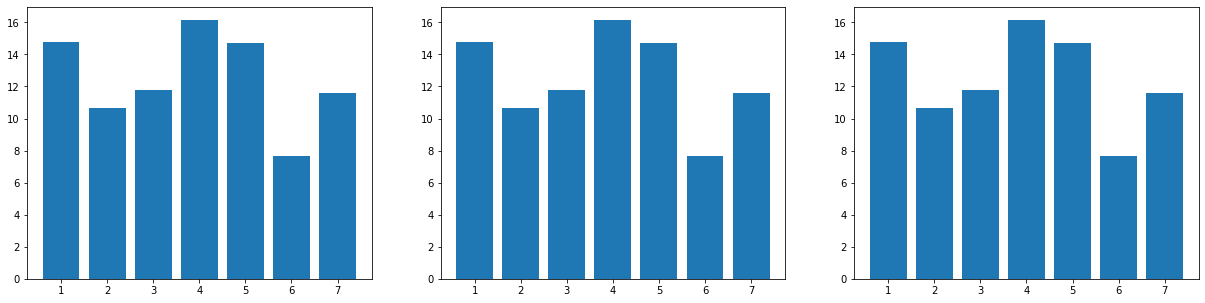

In [26]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr, lga, jfk]):
  ax[idx].bar(np.arange(1, 8), delays.groupby(['week day'])['dep_delay'].mean())
plt.show()

По построенным графикам видно, что максимальная задержка была в пн, чт и пт для всех аэропортов. Минимальная задержка была в сб для все аэропортов.

Построим диаграммы зависимости средней задержки от видимости.  

In [71]:
full = pd.merge(weather.drop('origin', 1), delays, on = ['year', 'month', 'day', 'hour'])
ewr_full = full[full['origin'] == 'EWR']
lga_full = full[full['origin'] == 'LGA']
jfk_full = full[full['origin'] == 'JFK']

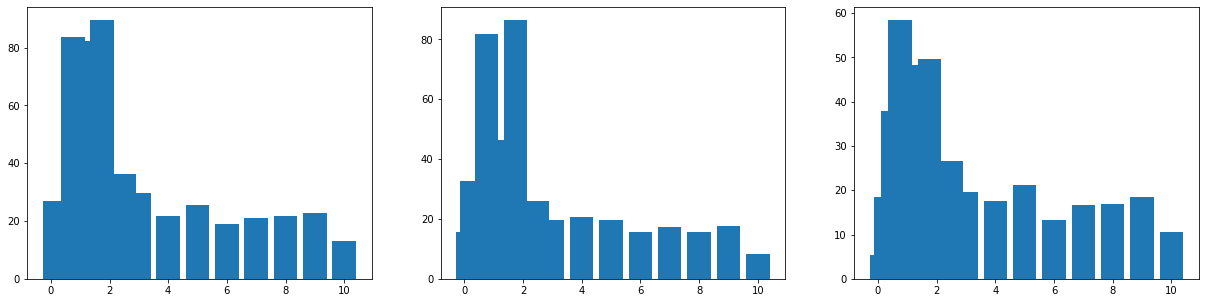

In [81]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  visib_uniq = airport['visib'].unique()
  visib_uniq.sort()
  ax[idx].bar(visib_uniq, airport.groupby('visib')['dep_delay'].mean())
plt.show()

Максимальная задержка у аэропортов EWR и LGA 80 при параметре видимости от 1 до 2, у JFK она 60-50 при параметре 1-2. В остальное же время задержка для всех аэропортов находится в районе 20.

Построим графики зависимости средней задержки от росы.

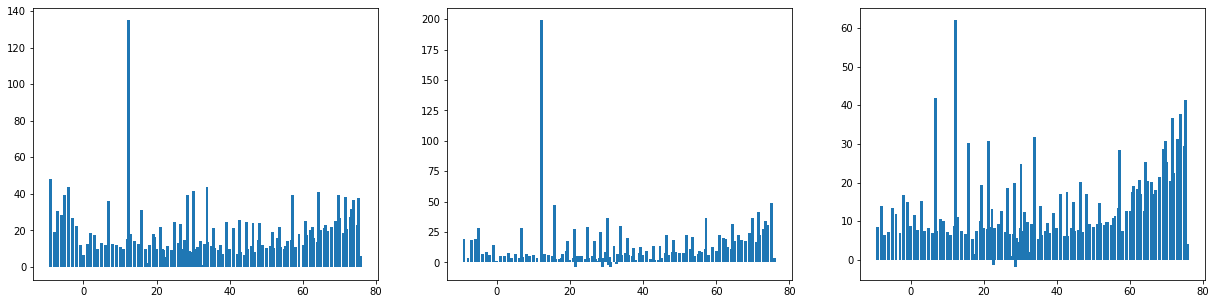

In [79]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  dewp_uniq = airport[airport['dewp'].notna()]['dewp'].unique()
  dewp_uniq.sort()
  ax[idx].bar(dewp_uniq, airport.groupby('dewp')['dep_delay'].mean())
plt.show()

Несмотря на наличие выбросов в данных для всех аэропортов, в среднем задержка увеличивается, при увеличении параметра росы.

Построим графики зависимости средней задержки от влажности.

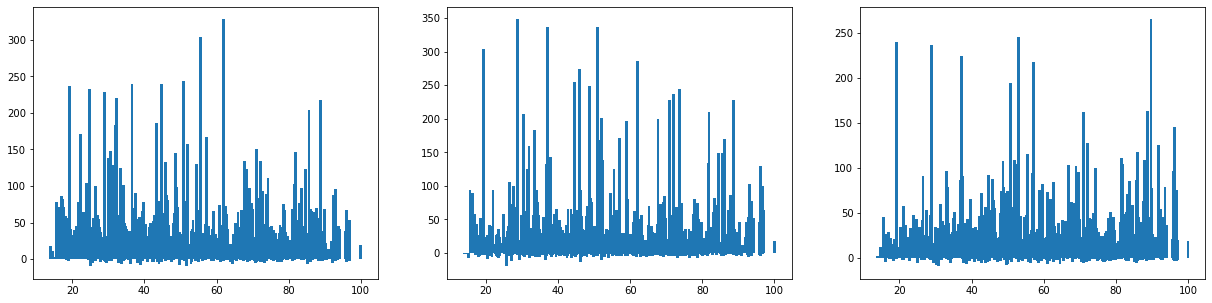

In [76]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  humid_uniq = airport[airport['humid'].notna()]['humid'].unique()
  humid_uniq.sort()
  ax[idx].bar(humid_uniq, airport.groupby('humid')['dep_delay'].mean())
plt.show()

По всем построенным графикам нельзя сделать какой-то однозначных вывод о завимости задержки от влажности, на графике очень много выбросов и нет измнения в среднем при увеличении или уменьшении влажности.

Построим графики зависимости средней задержки от направления ветра.

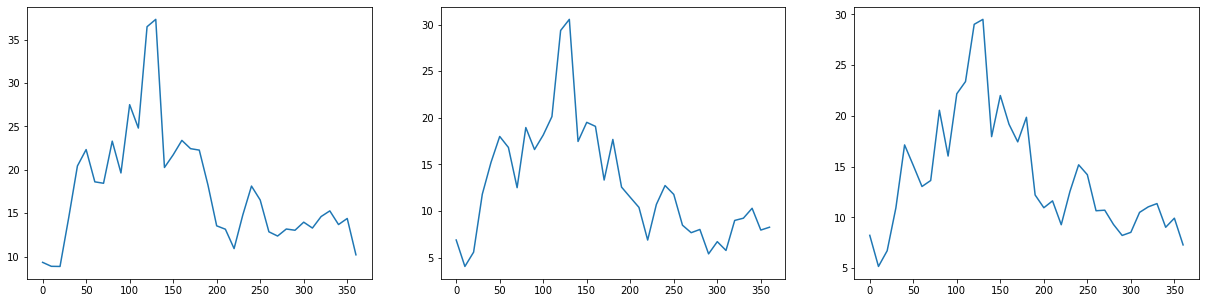

In [73]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  wind_dir_uniq = airport[airport['wind_dir'].notna()]['wind_dir'].unique()
  wind_dir_uniq.sort()
  ax[idx].plot(wind_dir_uniq, airport.groupby('wind_dir')['dep_delay'].mean())
plt.show()

Для всех 3 аэропортов ветер с направление ВВЮ вызывается максимальные задержки, а З-С минимальные.

Построим графики зависимости средней задержки от компании осуществляющей перевозку.

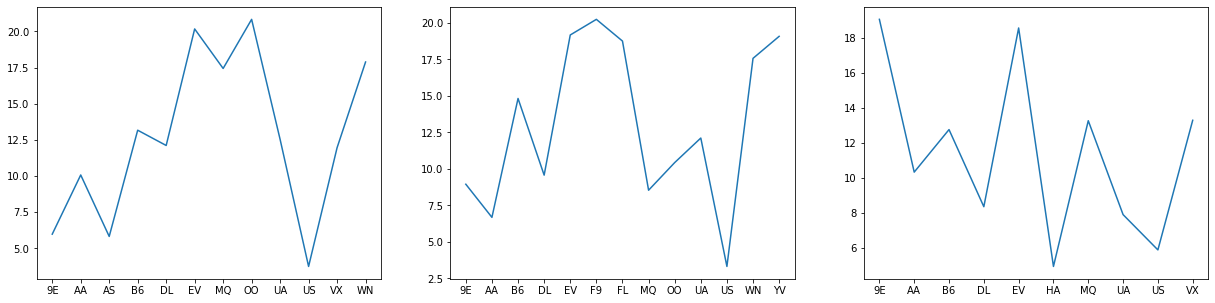

In [103]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  carrier_uniq = airport[airport['carrier'].notna()]['carrier'].unique()
  carrier_uniq.sort()
  ax[idx].plot(carrier_uniq, airport.groupby('carrier')['dep_delay'].mean())
plt.show()

Так например видно, что средние задержки перевозчика EV максимальны для всех аэропортов, что а значит это плохо говорит о компании в целом (если считать высокие задержки чем-то недостатком). А о перевозчике US можно сказать обратное.

Построим графики зависимости средней задержки от общей продолжительности полёта.

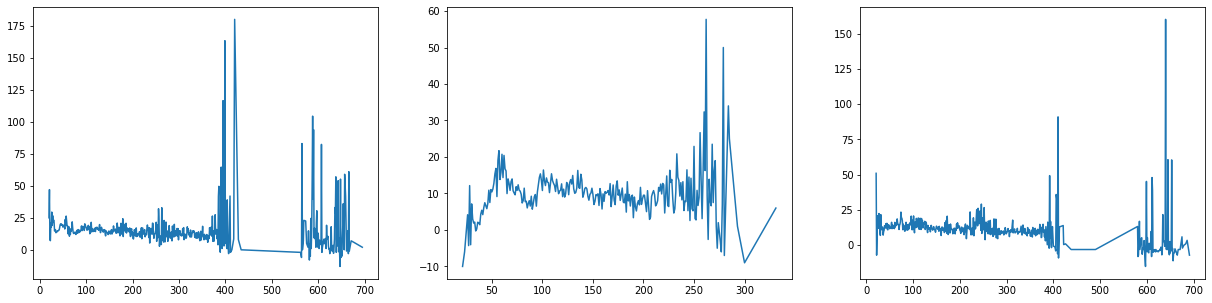

In [104]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  air_time_uniq = airport[airport['air_time'].notna()]['air_time'].unique()
  air_time_uniq.sort()
  ax[idx].plot(air_time_uniq, airport.groupby('air_time')['dep_delay'].mean())
plt.show()

Из графиков видно, что аэропорт LGA не занимается длителььными авиаперевозками. Также видно, что для всех аэропортов среднее время задержки больше при увеличении общей длительности.

Изучим также зависимость задержек от количества осадков.

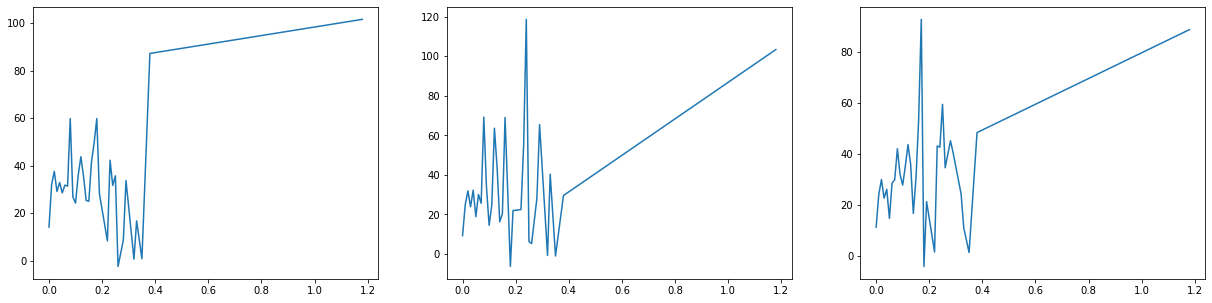

In [105]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  precip_uniq = airport[airport['precip'].notna()]['precip'].unique()
  precip_uniq.sort()
  ax[idx].plot(precip_uniq, airport.groupby('precip')['dep_delay'].mean())
plt.show()

In [ ]:
_, ax = plt.subplots(1, 3, figsize = (21, 5))
for idx, airport in enumerate([ewr_full , lga_full, jfk_full]):
  precip_uniq = airport[airport['precip'].notna()]['precip'].unique()
  precip_uniq.sort()
  ax[idx].plot(precip_uniq, airport.groupby('precip')['dep_delay'].mean())
plt.show()

По графикам видно, что до параметра 0.4 зависимость близка к случайной, в то время как после параметра 0.4 зависимость линейно растёт, что видимо говорит о наличии какой-то общей для всех аэропортов процедуры действия при больших осадках.

## Мы можем сделать вывод, что ряд параметров таких как время суток, время дня, тип компании могут быть использованы для предсказания задержки будущего рейса, также есть в целом не влияющие на удачность запуска параметры (конечно они могут влиять при каких-то особых обстоятельствах, однако в общем не получается выделить явную зависимость), как влажность.